# Adversarial Search: Playing "Mean" Connect 4


## Instructions

Total Points: Undegraduates 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with your implementation, documentation including a short discussion of how your implementation works and your design choices, and experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

You will implement different versions of agents that play "Mean" Connect 4:

> "Connect 4 is a two-player connection board game, in which the players choose a color and then take turns dropping colored discs into a seven-column, six-row vertically suspended grid. The pieces fall straight down, occupying the lowest available space within the column. The objective of the game is to be the first to form a horizontal, vertical, or diagonal line of four of one's own discs." (see [Connect Four on Wikipedia](https://en.wikipedia.org/wiki/Connect_Four))

> **The mean part:** This game has an additional rule. Every time it is a player's turn, the player can decide to instead of playing a new disk, take a bottom row disk of the opponent and place it in any column. All disks above the removed disk will fall down one position. Note that a player can only move an _opponent's disc_ that is in the _bottom row_ of the board.

Note that normal [Connect-4 has been solved](https://en.wikipedia.org/wiki/Connect_Four#Mathematical_solution)
in 1988. A connect-4 solver with a discussion of how to solve different parts of the problem can be found here: https://connect4.gamesolver.org/en/

## Task 1: Defining the Search Problem [1 point]

Define the components of the search problem associated with this game:

* Initial state
* Actions
* Transition model
* Test for the terminal state
* Utility for terminal states

Inital State: Empty 6 by 7 board <br>

Actions: place chip, replace chip from bottom and place chip in new column <br>

Transition Model: What it looks like when placing Chip aka how the board changes after a action <br>

Test for the terminal state: Check to see if there is 4 in a row of 1 or -1 including diagnol, vertical and horizontal.<br>

Utility for terminal state: 1, -1 or 0 is what we are checking for. <br>


How big is the state space? Give an estimate and explain it.

3 to 6*7

How big is the game tree that minimax search will go through? Give an estimate and explain it.

It will search through every Node that is available.

## Task 2: Game Environment and Random Agent [3 point]

You can use a numpy character array as the board. Note that the following function can create boards of different sizes.

In [1]:
import numpy as np

def empty_board(shape=(6, 7)):
    return np.full(shape=shape, fill_value=0)

print(empty_board())

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


Instead of colors (red and yellow), you can use 1 and -1 to represent the players Max and Min. Make sure that your agent functions all have the from: `agent_type(board, player = 1)`, where board is the current board position and player is the player (1, -1) whose next move it is and who the agent should play.

Visualization code by Randolph Rankin:

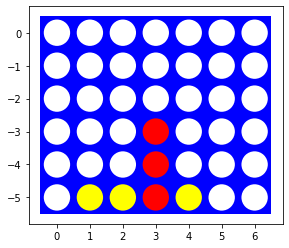

In [2]:
import matplotlib.pyplot as plt

def visualize(board):
    plt.axes()
    rectangle=plt.Rectangle((-0.5,len(board)*-1+0.5),len(board[0]),len(board),fc='blue')
    circles=[]
    for i,row in enumerate(board):
        for j,val in enumerate(row):
            color='white' if val==0 else 'red' if val==1 else 'yellow'
            circles.append(plt.Circle((j,i*-1),0.4,fc=color))

    plt.gca().add_patch(rectangle)
    for circle in circles:
        plt.gca().add_patch(circle)

    plt.axis('scaled')
    plt.show()
    
board = np.array([[0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0],
         [0,-1,-1, 1,-1, 0, 0]])

visualize(board)

Implement helper functions for:

* The transition model $results(s, a)$.
* The utility function $utility(s)$.
* Check for terminal states $terminal(s)$.
* A check for available actions in each state $actions(s)$.

Make sure that all these functions work with boards of different sizes (number of columns and rows).

In [3]:
from scipy.signal import convolve2d

In [4]:
kernels = [
    np.ones((1, 4), dtype=np.uint8),
    np.ones((4, 1), dtype=np.uint8),
    np.eye(4, dtype=np.uint8),
    np.fliplr(np.eye(4, dtype=np.uint8)),
]
def utlity(board: np.array) -> int:
    for kernel in kernels:
        for agent in [1, -1]:
            if (convolve2d(board == agent, kernel, mode="valid") == 4).any():
                return agent

    if 0 not in board:
        return 0

    return None

In [5]:
# Your code/ answer goes here.
def results(board, action: tuple,player):
    new_board = board.copy()
    dropper = board.shape[0]
    counter = dropper - 1
    if(action[0] == "place"):
        for i in range(0, dropper):
            if(new_board[counter][action[1]] == 0):
                new_board[counter][action[1]] = player
                break
            else:
                counter = counter - 1
    if(action[0] == "replace"):
        new_board.T[action[1]] = np.roll(board.T[action[1]],1)
        moving_peice = new_board.T[action[1]][0]
        new_board.T[action[1]][0] = 0
        for i in range(0, dropper):
            if(new_board[counter][action[2]] == 0):
                new_board[counter][action[2]] = moving_peice
                break
            else:
                counter = counter - 1
    # visualize(new_board)
    return new_board


In [6]:
def actions(board,player):
    isopen = [0 in x for x in board.T]
    for i,j in enumerate(board.T):
        if isopen[i]:
            yield ("place",i)
        if player == 1:
            if j[-1] == -1:
                for t,y in enumerate(isopen):
                    if y:
                        yield ("replace",i,t)
        if player == -1:
            if j[-1] == 1:
                for t,y in enumerate(isopen):
                    if y:
                        yield ("replace",i,t)

In [7]:
def terminal(board):
    return utlity(board) is not None

In [8]:
def player_change(player):
    if player == 1:
        return -1
    if player == -1:
        return 1

In [9]:
def start_game(p1,p2,board,moves):
    while moves > 0:
        win, board = player_steps(p1,1,board)
        moves -= 1
        
        if win == 1 or win == -1:
            print("Winner: ",win,)
            return win, board
        
        win, board = player_steps(p2,-1,board)
        moves -= 1
        
        if win == 1 or win == -1:
            print("Winner: ",win,)
            return win, board
    

In [10]:

def player_steps(func,player,board):
    # all_actions = actions(board,player)
    one_action = func(board,player)
    # print(one_action)
    board = results(board,one_action,player)
    if terminal(board):
        return utlity(board),board
    else:
        return None, board
    

Implement an agent that plays randomly. Make sure the agent function receives as the percept the board and returns a valid action.

In [11]:
def agent_random(board,player):
    get_actions = list(actions(board,player))
    return get_actions[np.random.choice(len(get_actions))]

Let two random agents play against each other 1000 times. Look at the [Experiments section for tic-tac-toe](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_and_or_tree_search.ipynb#Experiments) to see how ranom agents can play against each other.

How often does each player win? Is the result expected?

In [12]:
game_states = []
for i in range(1000):
    board = empty_board()
    state, board = start_game(agent_random,agent_random,board,100)
    game_states.append(state)

Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  -1
Winner:  -1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  -1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  -1
Winner:  -1
Winner:  1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  -1
Winner:  -1
Winner:  1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  1
Winner:  -1
Winner: 

In [13]:
print("1 Won: ", game_states.count(1), "-1 Won:", game_states.count(-1))

1 Won:  778 -1 Won: 222


   1 Wins  -1 Wins
0     778      222


<AxesSubplot:>

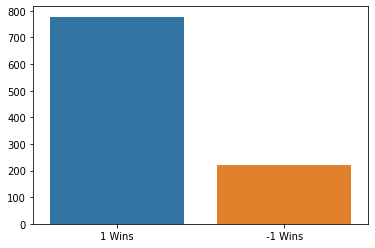

In [14]:
import seaborn as sb
import pandas as pd
data = {'1 Wins':[game_states.count(1)],'-1 Wins':[game_states.count(-1)]}
df = pd.DataFrame(data)
print(df)
sb.barplot(data=df)

We can conclude that first person that gets to move has an advantage. Out of the 1000 rounds player 1 who gets to move first won 76.9 percent of the time. 

## Task 3: Minimax Search with Alpha-Beta Pruning [3 points]

### Implement the search starting from a given board and specifying the player.

You can use code from the [tic-tac-toe example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_alpha_beta_tree_search.ipynb).


__Note:__ The game tree for a $6 \times 7$ board is large. You can experiment with smaller boards (the smallest is $4 \times 4$).

In [15]:
import math
DEBUG = 0
COUNT = 0

def alpha_beta_search(board, player):
    global DEBUG, COUNT
    COUNT = 0
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    # print(move)
    return move

def max_value_ab(state, player, alpha, beta):
    global DEBUG, COUNT
       
    # print("MAX")
    # return utility of state is a terminal state
    v = utlity(state)
    if DEBUG >= 1: print("max: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
        
    v, move = -math.inf, None

    # check all possible actions in the state, update alpha and return move with the largest value
    for a in actions(state,player):
        if(COUNT >20): return v,move
        v2, a2 = min_value_ab(results(state, a, player), player, alpha, beta)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    COUNT += 1
    return v, move

def min_value_ab(state, player, alpha, beta):
    # print("MIN")
    global DEBUG, COUNT
    
    # return utility of state is a terminal state
    v = utlity(state)
    if DEBUG >= 1: print("min: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
    
    v, move = +math.inf, None
    
    for a in actions(state,player):
        if(COUNT >20): return v,move
        v2, a2 = max_value_ab(results(state,a,player*-1), player, alpha, beta)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    COUNT += 1
    return v, move

Experiment with some manually created boards (at least 5) to check if the agent spots winning opportunities.

In [16]:
board1 = np.array([[0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [1, 1, 0, 0, 0]])
board2 = np.array([[0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, -1, -1, 1, 1],
                  [1, 1, 1, -1, -1]])
board3 = np.array([[0, 0, 0, 0, 0,0,0],
                  [0, 0, 0, 0, 0,0,0],
                  [0, 0, 0, 0, 0,0,0],
                  [0, 0, 0, 0, 0,0,0],
                  [1, 1, 0, 0, 0,0,0],
                  [1, 1, -1, -1, 1,1,0]])
board4 = np.array([[0, 0, 0, 0, 0,0,0],
                  [0, 0, 0, 0, 0,0,0],
                  [0, 0, 0, 0, 0,0,0],
                  [0, 0, 0, 1, 0,0,0],
                  [1, 1, 1, -1, 0,0,0],
                  [1, 1, -1, -1, 1,1,0]])
board5 = np.array([[0, 0, 0, 0, 0,0,0],
                  [0, 0, 0, 0, 0,0,0],
                  [0, 0, 0, 0, 0,0,0],
                  [-1, -1, 0, 0, -1,-1,1],
                  [1, -1, -1, -1, 1,1,1],
                  [1, 1, -1, -1, 1,1,1]])

board_list = []
board_list.append(board1)
board_list.append(board2)
board_list.append(board3)
board_list.append(board4)
board_list.append(board5)
winner_list = []
winner_board_list = []
for x in board_list:
    winner,winner_board = start_game(alpha_beta_search, alpha_beta_search, x, 100)
    winner_list.append(winner)
    winner_board_list.append(winner_board)

Winner:  1
Winner:  1
Winner:  1
Winner:  1
Winner:  1


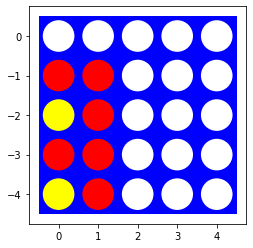

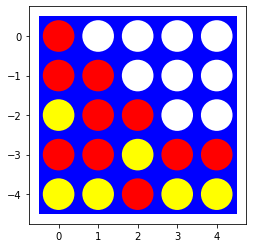

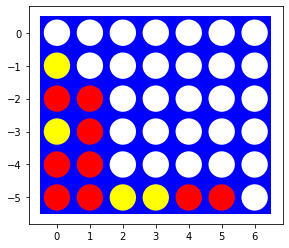

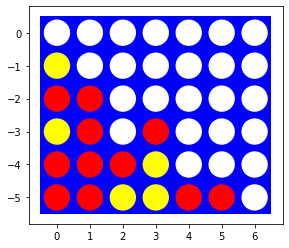

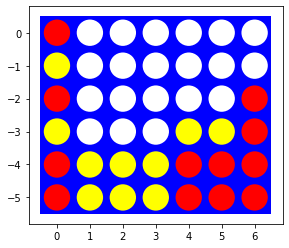

In [17]:
for x in winner_board_list:
    visualize(x)

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [18]:
import time 
board1 = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [1, 1, 0, 0],
                  [1, 1, 1, 0]])

board2 = np.array([[0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [-1, 1, 0, 0, 0],
                  [1, 1, 1, 0, 0]])
board3 = np.array([[0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [-1, 1, 0, 0, 0, 0],
                  [1, 1, 1, 0, 0, 0]])
board4 = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, -1, 0, 0, 0, 0, 0],
                  [-1, 1, 0, 0, 0, 0, 0],
                  [1, 1, 1, 0, 0, 0, 0]])

board_list = []
board_list.append(board1)
board_list.append(board2)
board_list.append(board3)
board_list.append(board4)
winner_list = []
winner_board_list = []
times = []
for x in board_list:
    start = time.time()
    winner,winner_board = start_game(alpha_beta_search, alpha_beta_search, x, 100)
    end = time.time()
    winner_list.append(winner)
    winner_board_list.append(winner_board)
    times.append(end-start)


Winner:  1
Winner:  1
Winner:  1
Winner:  1


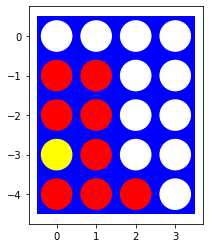

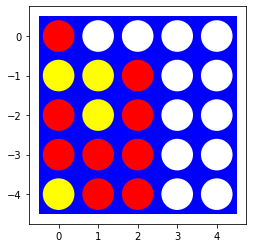

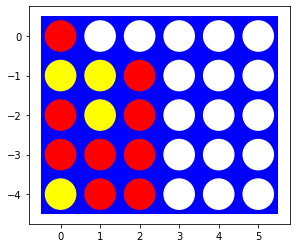

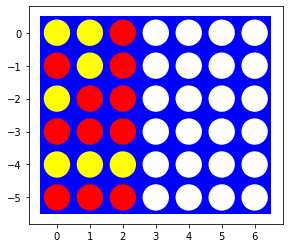

In [19]:
for x in winner_board_list:
    visualize(x)

        5x4    5x5       5x6       6x7
0  0.072999  0.164  0.229504  0.377997


<AxesSubplot:>

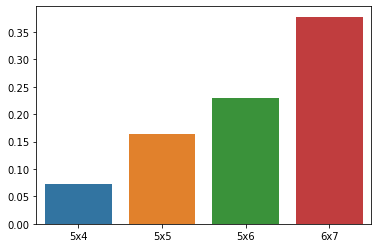

In [20]:
import seaborn as sb
import pandas as pd
data = {'5x4':[times[0]],'5x5':[times[1]],'5x6':[times[2]],'6x7':[times[3]]}
df = pd.DataFrame(data)
print(df)
sb.barplot(data=df)

### Move ordering

Describe and implement a simple move ordering strategy. Make a table that shows how the ordering strategies influence the time it takes to make a move?

In [21]:
import math
import random
DEBUG = 0
COUNT = 0

def alpha_beta_search_ReverseMoveOrdering(board, player):
    global DEBUG, COUNT
    COUNT = 0
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    if DEBUG >= 1: print(f"Number of nodes searched: {COUNT}") 
    # print(move)
    return move

def max_value_ab(state, player, alpha, beta):
    global DEBUG, COUNT
       
    # return utility of state is a terminal state
    v = utlity(state)
    if DEBUG >= 1: print("max: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
        
    v, move = -math.inf, None
    actions_list = []
    for a in actions(state,player):
        actions_list.append(a)
    random.shuffle(actions_list)
    # actions_list = actions_list[-1:] + actions_list[:-1]
    for a in actions_list:
        if(COUNT >20): return v,move
        v2, a2 = min_value_ab(results(state, a, player), player, alpha, beta)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    # print("MAX",v,move)
    COUNT += 1
    return v, move

def min_value_ab(state, player, alpha, beta):
    """opponent's best response."""
    global DEBUG, COUNT
    
    # return utility of state is a terminal state
    v = utlity(state)
    if DEBUG >= 1: print("min: " + str(state) + str([alpha, beta, v]) ) 
    if v is not None: return v, None
    
    v, move = +math.inf, None
    actions_list = []
    for a in actions(state,player):
        actions_list.append(a)
    random.shuffle(actions_list)
    # actions_list = actions_list[-1:] + actions_list[:-1]
    for a in actions_list:
        if(COUNT >20): return v,move
        v2, a2 = max_value_ab(results(state,a,player*-1), player, alpha, beta)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    COUNT += 1
    return v, move

In [22]:
import time 
board1 = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [1, 1, 0, 0],
                  [1, 1, 1, 0]])

board2 = np.array([[0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [-1, 1, 0, 0, 0],
                  [1, 1, 1, 0, 0]])
board3 = np.array([[0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [1, 1, 0, 0, 0, 0],
                  [1, 1, 1, -1,-1, 1]])
board4 = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, -1, 0, 0, 0, 0, 0],
                  [1, 1, 0, 0, 0, 0, 0],
                  [1, 1, 1, -1, 1, 1, 1]])
board_list = []
board_list.append(board1)
board_list.append(board2)
board_list.append(board3)
board_list.append(board4)
winner_list = []
winner_board_list = []
times2 = []
for x in board_list:
    start = time.time()
    winner,winner_board = start_game(alpha_beta_search_ReverseMoveOrdering, alpha_beta_search_ReverseMoveOrdering, x, 100)
    end = time.time()
    winner_list.append(winner)
    winner_board_list.append(winner_board)
    times2.append(end-start)


Winner:  1
Winner:  1
Winner:  1
Winner:  1


                 5x4       5x5       5x6       6x7
No ReOrder  0.072999  0.164000  0.229504  0.377997
Reordered   0.057501  0.063501  0.169000  0.123000


<AxesSubplot:>

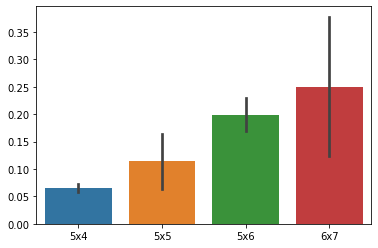

In [23]:
import seaborn as sb
import pandas as pd
data = {'5x4':[times[0],times2[0]],'5x5':[times[1],times2[1]],'5x6':[times[2],times2[2]],'6x7':[times[3],times2[3]]}
df = pd.DataFrame(data,index=["No ReOrder","Reordered"])
print(df.head())
sb.barplot(data=df)

### The first few moves

Start with an empty board. This is the worst case scenario for minimax search with alpha-beta pruning since it needs solve all possible games that can be played (minus some pruning) before making the decision. What can you do? 

When it comes to my algorithum it does not like it when there is an empyty board and ends up crashing the kernal. In order to get around this I place a 1 on the bottom row of the board to kick start the algo. 

In [ ]:
board1 = np.array([[1, 0, 0, 0],
                  [1, 0, 0, 0],
                  [1, 0, 0, 0],
                  [1, 0, 0, 0]])
winner,winner_board = start_game(alpha_beta_search, alpha_beta_search, board1, 100)

### Playtime

Let the Minimax Search agent play a random agent on a small board. Analyze wins, losses and draws.

In [16]:
winner_list = []

In [17]:
board1 = np.array([[0, 0, 0, 0],
                  [-1, 0, 0, 0],
                  [1, -1, 1, -1],
                  [1, 1, -1, -1]])
winner_list = []
for i in range(5):
    winner,winner_board = start_game(alpha_beta_search,agent_random, board1, 1000)
    winner_list.append(winner)
    

Winner:  1
Winner:  1
Winner:  -1
Winner:  1
Winner:  -1


<AxesSubplot:>

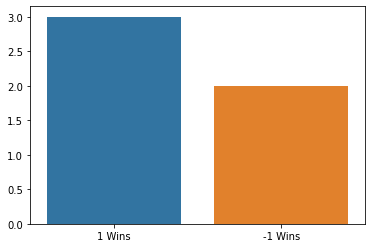

In [18]:
import seaborn as sb
import pandas as pd
data = {'1 Wins':[winner_list.count(1)],'-1 Wins':[winner_list.count(-1)]}
df = pd.DataFrame(data)
sb.barplot(data=df)

## Task 4: Heuristic Alpha-Beta Tree Search [3 points] 

### Heuristic evaluation function

Define and implement a heuristic evaluation function.

In [31]:
# Your code/ answer goes here.

### Cutting off search 

Modify your Minimax Search with Alpha-Beta Pruning to cut off search at a specified depth and use the heuristic evaluation function. Experiment with different cutoff values.

In [16]:
import math
import random
DEBUG = 0
COUNT = 0

def alpha_beta_search_ReverseMoveOrdering(board, player):
    global COUNT
    COUNT = 0
    value, move = max_value_ab(board, player, -math.inf, +math.inf)
    return move

def max_value_ab(state, player, alpha, beta):
    global COUNT
       
    v = utlity(state)
    if v is not None: return v, None
        
    v, move = -math.inf, None
    for a in actions(state,player):
        if(COUNT >50): return v,move
        v2, a2 = min_value_ab(results(state, a, player), player, alpha, beta)
        if v2 > v:
            v, move = v2, a
            alpha = max(alpha, v)
        if v >= beta: return v, move
    # print("MAX",v,move)
    COUNT += 1
    return v, move

def min_value_ab(state, player, alpha, beta):

    global COUNT
    
    v = utlity(state)
    if v is not None: return v, None
    
    v, move = +math.inf, None
    for a in actions(state,player):
        if(COUNT >50): return v,move
        v2, a2 = max_value_ab(results(state,a,player*-1), player, alpha, beta)
        if v2 < v:
            v, move = v2, a
            beta = min(beta, v)
        if v <= alpha: return v, move
    COUNT += 1
    return v, move

In [ ]:
import time 
board1 = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [1, 1, 0, 0],
                  [1, 1, 1, 0]])

board2 = np.array([[0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [-1, 1, 0, 0, 0],
                  [1, 1, 1, 0, 0]])
board3 = np.array([[0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0],
                  [-1, 1, 0, 0, 0, 0],
                  [1, 1, 1, 0, 0, 0]])
board4 = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, -1, 0, 0, 0, 0, 0],
                  [-1, 1, 0, 0, 0, 0, 0],
                  [1, 1, 1, 0, 0, 0, 0]])

board_list = []
board_list.append(board1)
board_list.append(board2)
board_list.append(board3)
board_list.append(board4)
winner_list = []
winner_board_list = []
times = []
for x in board_list:
    start = time.time()
    winner,winner_board = start_game(alpha_beta_search, alpha_beta_search, x, 100)
    end = time.time()
    winner_list.append(winner)
    winner_board_list.append(winner_board)
    times.append(end-start)


Experiment with the same manually created boards as above to check if the agent spots winning opportunities.

In [33]:
# Your code/ answer goes here.

How long does it take to make a move? Start with a smaller board with 4 columns and make the board larger by adding columns.

In [34]:
# Your code/ answer goes here.

### Playtime

Let two heuristic search agents (different cutoff depth, different heuristic evaluation function) compete against each other on a reasonably sized board. Since there is no randomness, you only need to let them play once.

In [35]:
# Your code/ answer goes here.

## Tournament task [+ 1 to 5 bonus point will be assigned separately]

Find another student and let your best agent play against the other student's best player. You are allowed to use any improvements you like as long as you code it yourself. We will set up a class tournament on Canvas. This tournament will continue after the submission deadline.

## Graduate student advanced task: Pure Monte Carlo Search and Best First Move [1 point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

### Pure Monte Carlo Search

Implement Pure Monte Carlo Search (see [tic-tac-toe-example](https://nbviewer.org/github/mhahsler/CS7320-AI/blob/master/Games/tictactoe_pure_monte_carlo_search.ipynb)) and investigate how this search performs on the test boards that you have used above. 

In [36]:
# Your code/ answer goes here.

### Best First Move

How would you determine what the best first move for a standard board ($6 \times 7$) is? You can use Pure Monte Carlo Search or any algorithms that you have implemented above.

In [37]:
# Your code/ answer goes here.